In [73]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score


In [74]:
#Loading data

product = pd.read_csv("C:\\Users\\nguye\\OneDrive\\Documents\\question-data\\data\\product.csv")
sales = pd.read_csv("C:\\Users\\nguye\\OneDrive\\Documents\\question-data\\data\\sales.csv")


#Process data
product = product[['brand', 'flavour', 'volume_per_joghurt_g', 'packsize','product_id']]
sales = sales[['date', 'product_id', 'price', 'units']]
df = pd.merge(product, sales, on ='product_id')
df = df[['date','brand', 'flavour', 'volume_per_joghurt_g', 'packsize', 'price', 'units']]
# Convert date column to datetime
df['date'] = pd.to_datetime(df['date'])


1. Descriptive Analysis

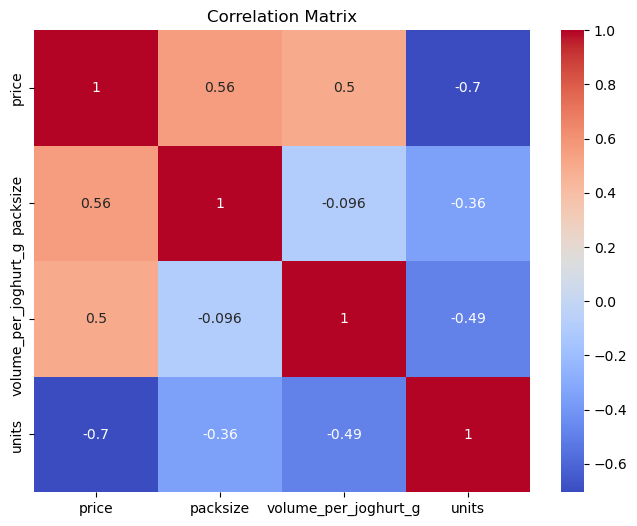

In [75]:
# Correlation Heatmap between variables
plt.figure(figsize=(8, 6))
sns.heatmap(df[['price', 'packsize', 'volume_per_joghurt_g', 'units']].corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Matrix")
plt.show()

Insights:

- Sales (units) show a negative correlation with price, suggesting price sensitivity.

- Volume per jogurt and packsize have moderate negative correlation with sellouts, seems like smaller packs and volumns might be linked to higher sales.

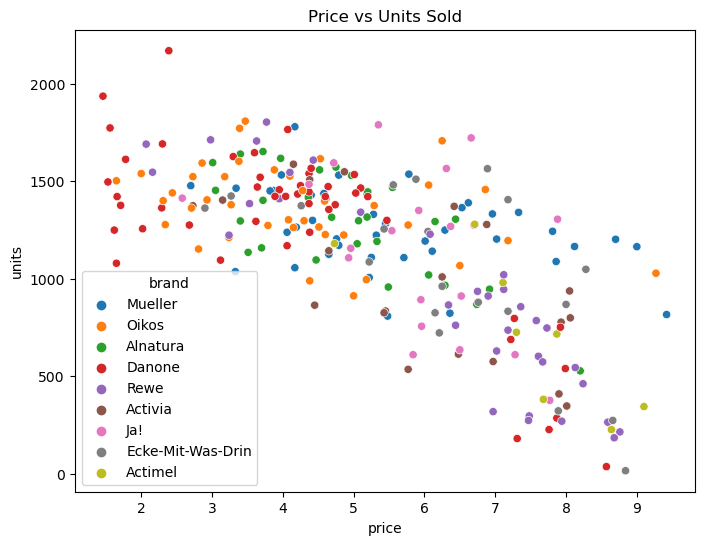

In [76]:
# Scatter Plot: Price vs Units Sold
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df, x='price', y='units', hue='brand')
plt.title("Price vs Units Sold")
plt.show()


Insights:

As price increases, units sold generally decrease.

This price elasticity varies by brand.

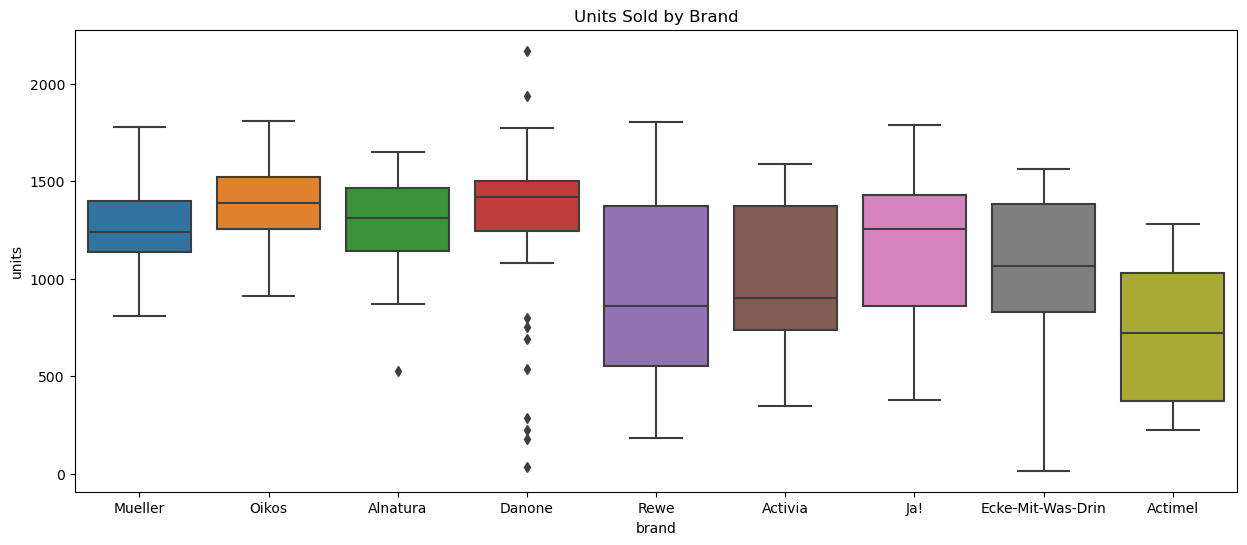

In [80]:
# Box Plot: Units Sold by Brand
plt.figure(figsize=(15, 6))
sns.boxplot(data=df, x='brand', y='units')
plt.title("Units Sold by Brand")
plt.show()


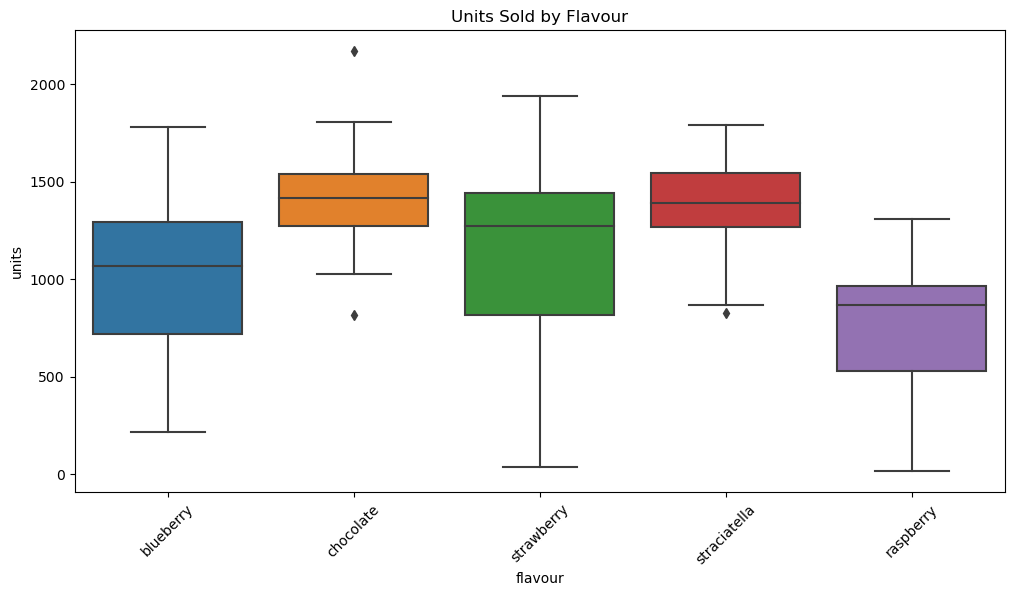

In [78]:
# Box Plot: Units Sold by Flavour
plt.figure(figsize=(12, 6))
sns.boxplot(data=df, x='flavour', y='units')
plt.title("Units Sold by Flavour")
plt.xticks(rotation=45)
plt.show()

Insights:

Some brands and flavours consistently outperform others in units sold.

There is high variability across products, implying potential brand/flavour loyalty or preferences.


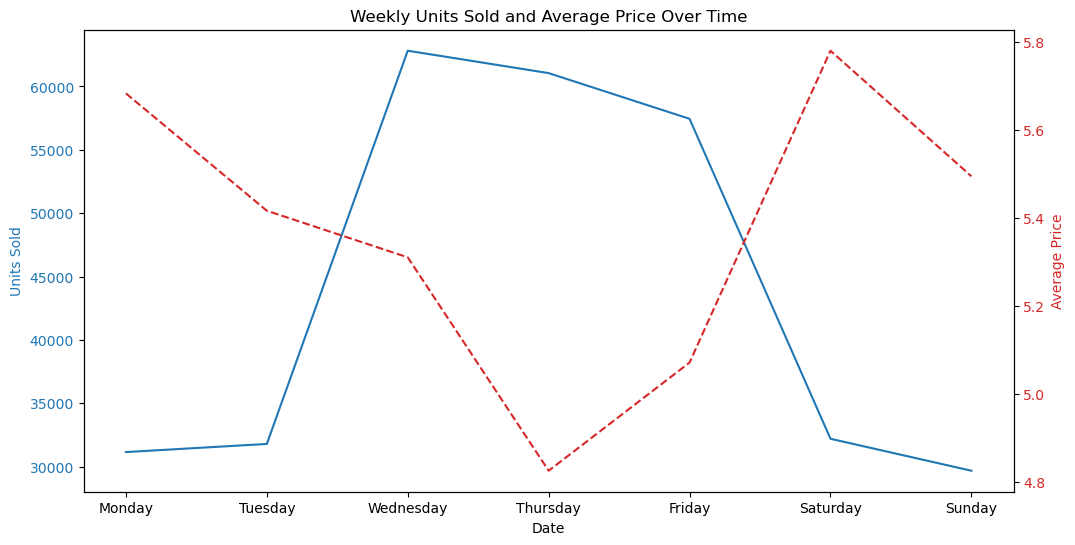

In [ ]:
#Line Plot: Units and Price Over Time (aggregated by week)

weekdate_dict = {'Monday':1,
                 'Tuesday':2,
                 'Wednesday':3,
                 'Thursday':4,
                 'Friday':5,
                 'Saturday':6,
                 'Sunday':7}

df['weekday'] = df['date'].dt.day_name()
df['order'] = df['weekday'].map(weekdate_dict)
df_weekly = df.groupby(['order','weekday']).agg({'units': 'sum', 'price': 'mean'}).droplevel(level=0)

fig, ax1 = plt.subplots(figsize=(12, 6))

color = 'tab:blue'
ax1.set_xlabel('Date')
ax1.set_ylabel('Units Sold', color=color)
ax1.plot(df_weekly.index, df_weekly['units'], color=color, label='Units Sold')
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Average Price', color=color)
ax2.plot(df_weekly.index, df_weekly['price'], color=color, linestyle='--', label='Average Price')
ax2.tick_params(axis='y', labelcolor=color)

plt.title("Weekly Units Sold and Average Price Over Time")
plt.show()

Insights:
Sales & Price Over Time:

Weekly sales volumes fluctuate and may follow patterns (e.g., promotions or seasonality).

Average prices also shift over time, possibly aligned with marketing or seasonal events.

Trend: lower prices on Wed - Friday -> higher Unit sold

2. Develop a simple model predicting units from prices (e.g. using elasticities) for all products, so a model describing the distribution (or a point estimate) of units | price, product attributes. Fit the model to the data and provide some estimate of the risk of your model against a baseline.

In [ ]:
# One-hot encode categorical features
df_encoded = pd.get_dummies(df, columns=['brand', 'flavour', 'weekday'], drop_first=True)

# Split features and target
X = df_encoded.drop(columns=['units', 'date'])  # Exclude target and date
y = df_encoded['units']

# Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Model
model = LinearRegression()
model.fit(X_train, y_train)

# Predict and Evaluate
y_pred = model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

# Baseline Model (predict mean of training set)
baseline_pred = np.full_like(y_test, y_train.mean())
baseline_rmse = np.sqrt(mean_squared_error(y_test, baseline_pred))
baseline_r2 = r2_score(y_test, baseline_pred)

# Step 9: Print Results
print("Linear Regression Performance:")
print(f"  RMSE: {rmse:.2f}")
print(f"  R²: {r2:.3f}")
print("Baseline Performance:")
print(f"  RMSE: {baseline_rmse:.2f}")
print(f"  R²: {baseline_r2:.3f}")

Linear Regression Performance:
  RMSE: 237.47
  R²: 0.712
Baseline Performance:
  RMSE: 463.56
  R²: -0.097


Insights:
Linear Regression model's predictions deviate from actual consumption by about 237.47 units, on average and can explain about 71.2% of the variation in sales which are better than Baseline Performance


3. Demonstrate how your model can be used to support revenue optimization. Utilize the ability to simulate different price and product offering strategies and interpret simulation results in the business context at hand. 

Let the price range from 0.5 - 10 euro to see how sellout would be using the model in part 2 and see how revenue change using the eslasticity

In [ ]:
def predict_sellout(price, elasticity, intercept):
    predicted_quantity = intercept + elasticity * price
    return predicted_quantity

# Get the model's intercept
intercept = model.intercept_

# Get the model's coefficient (price elasticity)
elasticity = model.coef_[0]

# Example: Forecast sellout at different price points
prices = np.linspace(0.5, 10, 30)
for price in prices:
    sellout = predict_sellout(price, elasticity, intercept)
    print(f"If price is {price:.2f}, predicted sellout is {sellout:.2f}, predicted revenue is {(sellout * price):.2f}")


If price is 0.50, predicted sellout is 1744.73, predicted revenue is 872.36
If price is 0.83, predicted sellout is 1744.70, predicted revenue is 1443.89
If price is 1.16, predicted sellout is 1744.68, predicted revenue is 2015.40
If price is 1.48, predicted sellout is 1744.65, predicted revenue is 2586.90
If price is 1.81, predicted sellout is 1744.63, predicted revenue is 3158.38
If price is 2.14, predicted sellout is 1744.61, predicted revenue is 3729.85
If price is 2.47, predicted sellout is 1744.58, predicted revenue is 4301.30
If price is 2.79, predicted sellout is 1744.56, predicted revenue is 4872.74
If price is 3.12, predicted sellout is 1744.54, predicted revenue is 5444.16
If price is 3.45, predicted sellout is 1744.51, predicted revenue is 6015.56
If price is 3.78, predicted sellout is 1744.49, predicted revenue is 6586.95
If price is 4.10, predicted sellout is 1744.46, predicted revenue is 7158.32
If price is 4.43, predicted sellout is 1744.44, predicted revenue is 7729.68


But this result does not really give feedback how to change price of any particular product to optimize the revenue. Next step can be the apply the price for one by one particular product + flavor + volumn + packsize to see which price can optimize the revenue

By using the coefficients from the model, for incresing sales units of Mueller, keeping the price, there are suggestions 
1. By increase offering smaller volumn products (volume have negative correlation with sales)
2. Chocolate, straciatella flavors have highest contribution to unit sold according to the model, the other flavour can possible have more promotions or price reduction for increase units sold


In [ ]:
for x, y in zip(model.feature_names_in_, model.coef_):
    print(f"coef of {x}: {y:.2f}")

coef of volume_per_joghurt_g: -0.07
coef of packsize: -29.07
coef of price: -106.94
coef of brand_Activia: -101.92
coef of brand_Alnatura: 120.29
coef of brand_Danone: -7.13
coef of brand_Ecke-Mit-Was-Drin: 46.58
coef of brand_Ja!: 80.97
coef of brand_Mueller: 117.46
coef of brand_Oikos: -13.35
coef of brand_Rewe: -80.28
coef of flavour_chocolate: 335.12
coef of flavour_raspberry: -50.77
coef of flavour_straciatella: 307.20
coef of flavour_strawberry: -29.13
coef of weekday_Monday: 43.30
coef of weekday_Saturday: 131.23
coef of weekday_Sunday: 3.56
coef of weekday_Thursday: 27.73
coef of weekday_Tuesday: 46.95
coef of weekday_Wednesday: 65.12
